In [1]:
import sys
sys.path.append('C:/Users/Nishant Joshi/Model_fitting/GIFFittingToolbox/src')
from Experiment import *
from AEC_Badel import *
from GIF import *
from Filter_Rect_LogSpaced import *
from Filter_Rect_LinSpaced import *
import pickle
import matplotlib.pyplot as plt
from Filter_Exps import * 
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from utils import * 


In [2]:
def get_gamma_factor(modelspks, dataspks, delta, time, dt, rate_correction=True):
    """
    Calculate gamma factor between model and target spike trains,
    with precision delta.

    Parameters
    ----------
    model: `list` or `~numpy.ndarray`
        model trace
    data: `list` or `~numpy.ndarray`
        data trace
    delta: `~brian2.units.fundamentalunits.Quantity`
        time window
    dt: `~brian2.units.fundamentalunits.Quantity`
        time step
    time: `~brian2.units.fundamentalunits.Quantity`
        total time of the simulation
    rate_correction: bool
        Whether to include an error term that penalizes differences in firing
        rate, following `Clopath et al., Neurocomputing (2007)
        <https://doi.org/10.1016/j.neucom.2006.10.047>`_.

    """
    model = np.array(modelspks)
    data = np.array(dataspks)

    model = np.array(np.int32(model / dt), dtype=int)
    data = np.array(np.int32(data / dt), dtype=int)
    delta_diff = int(np.int32(delta / dt))

    model_length = len(model)
    data_length = len(data)
    # data_rate = firing_rate(data) * Hz
    data_rate = data_length / time
    model_rate = model_length / time

    if model_length > 1:
        bins = .5 * (model[1:] + model[:-1])
        indices = np.digitize(data, bins)
        diff = np.abs(data - model[indices])
        matched_spikes = (diff <= delta_diff)
        coincidences = np.sum(matched_spikes)
    elif model_length == 0:
        coincidences = 0
    else:
        indices = [np.amin(abs(model - data[i])) <= delta_diff for i in np.arange(data_length)]
        coincidences = sum(indices)

    # Normalization of the coincidences count
    NCoincAvg = 2 * delta * data_length * data_rate
    norm = .5*(1 - 2 * data_rate * delta)
    gamma = (coincidences - NCoincAvg)/(norm*(model_length + data_length))

    if rate_correction:
        rate_term = 1 + 2*np.abs((data_rate - model_rate)/data_rate)
    else:
        rate_term = 1
    return gamma

    # return np.clip(rate_term - gamma, 0, np.inf)


In [3]:
"""
This file shows how to fit a GIF to some experimental data.
More instructions are provided on the website. 
"""
############################################################################################################
# STEP 1: LOAD EXPERIMENTAL DATA
############################################################################################################
myExp = Experiment('Experiment 1', 0.05)

#Load Data from the Dataset
# trial = 0
# data = loadmatInPy('D:/Analyzed/NC_170711_aCSF_D1ago_E1_analyzed.mat')
# I_data =      data[trial]['input_current'][:120*20000]
# V_data =      data[trial]['membrane_potential'][:120*20000]
# spikes_data = data[trial]['spikeindices']    


#Inhibitory
with open("G:/My Drive/Bernstein/170725_NC_82_INH.pickle",'rb') as f:
    data = pickle.load(f)
I_data = data['I'][:120*20000]
V_data = data['V'][:120*20000]
spikes_data = data['spikes']    

#Excitatory

# with open("G:/My Drive/Bernstein/170815_NC_109_EXC.pickle",'rb') as f:
#     data = pickle.load(f)
# I_data = data['I'][:120*20000]
# V_data = data['V'][:120*20000]
# spikes_data = data['spikes']    

# Load AEC data
myExp.setAECTrace(V_data[:int(10*20000)],1e-3,I_data[:int(10*20000)] ,1e-12, 10000.0, FILETYPE='Array')

# Load training set data
myExp.addTrainingSetTrace(V_data,1e-3,I_data, 1e-12, 120000.0, FILETYPE='Array')


## Perform AEC


PERFORM ACTIVE ELECTRODE COMPENSATION (Badel method)...

Estimate electrode properties...


C:\Users/Nishant Joshi/Model_fitting/GIFFittingToolbox/src\Filter.py:400: RuntimeWarning: overflow encountered in exp
  result = result + bs[i] *np.exp(-x/taus[i])


Repetition  1  R_e (MOhm) = 24.21
Repetition  2  R_e (MOhm) = 23.10
Repetition  3  R_e (MOhm) = 23.21
Repetition  4  R_e (MOhm) = 23.70
Repetition  5  R_e (MOhm) = 24.07
Repetition  6  R_e (MOhm) = 23.50
Repetition  7  R_e (MOhm) = 23.20
Repetition  8  R_e (MOhm) = 23.57
Repetition  9  R_e (MOhm) = 23.47
Repetition  10  R_e (MOhm) = 23.58
Repetition  11  R_e (MOhm) = 24.19
Repetition  12  R_e (MOhm) = 24.04
Repetition  13  R_e (MOhm) = 24.23


C:\Users/Nishant Joshi/Model_fitting/GIFFittingToolbox/src\Filter.py:400: RuntimeWarning: overflow encountered in multiply
  result = result + bs[i] *np.exp(-x/taus[i])


Repetition  14  R_e (MOhm) = 23.50
Repetition  15  R_e (MOhm) = 23.46
Done!
Compensate experiment
AEC trace...
I_tmp (200000,)
F (140,)
Training set...
I_tmp (2400000,)
F (140,)
Test set...
Done!


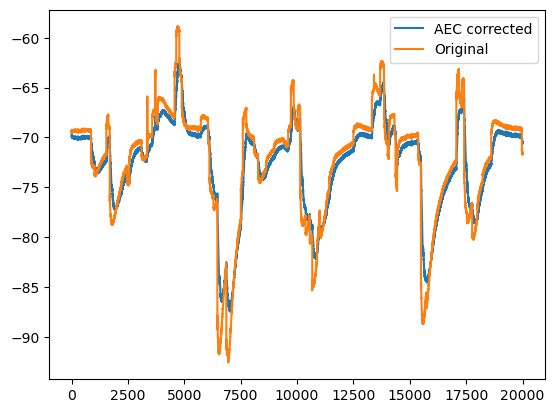

In [198]:
############################################################################################################
# STEP 2: ACTIVE ELECTRODE COMPENSATION
############################################################################################################

# Create new object to perform AEC
myAEC = AEC_Badel(myExp.dt)

# Define metaparametres
myAEC.K_opt.setMetaParameters(length=150.0, binsize_lb=myExp.dt, binsize_ub=2.0, slope=30.0, clamp_period=1.0)
myAEC.p_expFitRange = [3.0,150.0]  
myAEC.p_nbRep = 15     

# Assign myAEC to myExp and compensate the voltage recordings
myExp.setAEC(myAEC)  
myExp.performAEC()  

plt.plot(myExp.trainingset_traces[0].V[:1*20000],label='AEC corrected')
plt.plot(V_data[:1*20000],label='Original')
plt.legend()
plt.show()
# # Plot AEC filters (Kopt and Ke)
# myAEC.plotKopt()
# myAEC.plotKe()

# # Plot training and test set
# myExp.plotTrainingSet()
# myExp.plotTestSet()


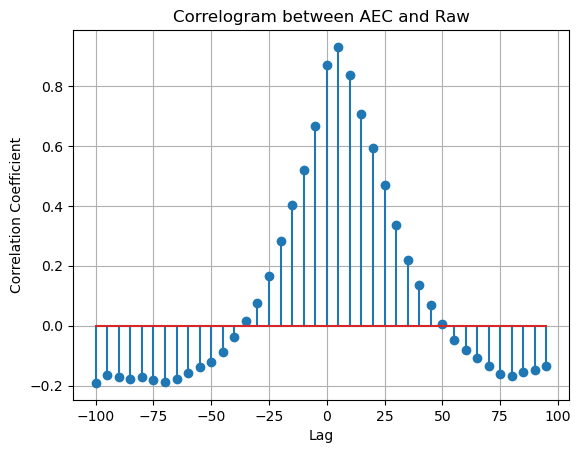

In [187]:
from scipy import signal
def plot_correlations(sig1,sig2,tau,str1,str2,ax):
    signal1 = sig1-np.mean(sig1)
    signal2 = sig2-np.mean(sig2)
    # Calculate cross-correlation with maximum lag of 20
    correlation = signal.correlate(signal1, signal2 , mode='full')
    correlation /= np.sqrt(np.sum(signal1**2)*np.sum(signal2**2))    
    lags = signal.correlation_lags(len(signal1), len(signal1))

    # Plot the correlogram
    # lags = np.arange(-tau,tau,1/20)
    # plt.stem(lags[::100], correlation[len(correlation)//2-tau*20:len(correlation)//2+tau*20][::100])
    ax.stem(lags[len(lags)//2-100*20:len(lags)//2+100*20:100]/20, correlation[len(lags)//2-100*20:len(lags)//2+100*20:100])

    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Correlogram between {str1} and {str2}')
    ax.grid(True)
    # plt.show()

fig,ax = plt.subplots()
plot_correlations(myExp.trainingset_traces[0].V[:1*20000],V_data[:1*20000],100,'AEC','Raw',ax)

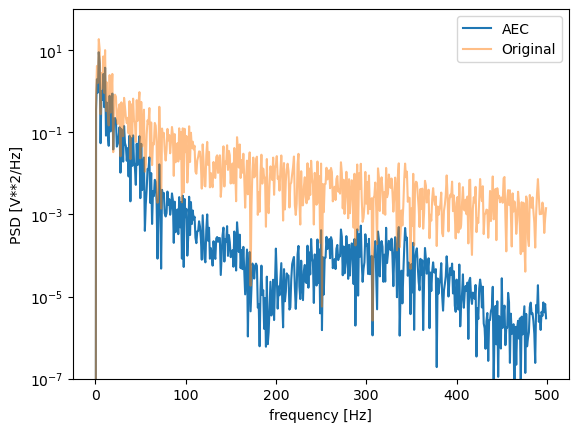

In [188]:
fs = 20000
x = myExp.trainingset_traces[0].V[:1*20000]
f, Pxx_den = signal.periodogram(x, fs)
y = V_data[:1*20000]
f, Pyy_den = signal.periodogram(y, fs)

plt.semilogy(f[:500], Pxx_den[:500],label='AEC')
plt.semilogy(f[:500], Pyy_den[:500],alpha=0.5,label='Original')

plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

## Fit the data

In [4]:
############################################################################################################
# STEP 3: FIT GIF MODEL TO DATA
############################################################################################################

# Create a new object GIF 
myGIF = GIF(0.05)

# Define parameters
myGIF.Tref = 4.0  

#Rectangular Filter
myGIF.eta = Filter_Rect_LogSpaced()
myGIF.eta.setMetaParameters(length=500.0, binsize_lb=1.0, binsize_ub=1000.0, slope=4.5)

myGIF.gamma = Filter_Rect_LogSpaced()
myGIF.gamma.setMetaParameters(length=500.0, binsize_lb=1.0, binsize_ub=1000.0, slope=5.0)


# Exp Filter
# myGIF.eta = Filter_Exps()
# myGIF.eta.setFilter_Timescales([1.0, 5.0, 30.0, 70.0, 100.0, 500.0])
# myGIF.gamma = Filter_Exps()
# myGIF.gamma.setFilter_Timescales([1.0, 5.0, 30.0, 70.0, 100.0, 500.0])

# Define the ROI of the training set to be used for the fit (in this example we will use only the first 100 s)
myExp.trainingset_traces[0].setROI([[0,100000.0]])

# To visualize the training set and the ROI call again
myExp.detectSpikes_python()
# myExp.plotTrainingSet()





Detect spikes!
Done!


In [5]:
# Perform the fit
myGIF.fit(myExp, DT_beforeSpike=5.0)

################################
# Fit GIF
################################
Estimate voltage reset (Tref = 4.0 ms)...
Done! Vr = -55.19 mV (computed on 365 spikes)

GIF MODEL - Fit subthreshold dynamics...
Compute X matrix for repetition 1

Perform linear regression...

-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	3.393
R (MOhm):	119.371
C (nF):		0.028
gl (nS):	0.008377
El (mV):	-52.260
Tref (ms):	4.000
Vr (mV):	-55.185
Vt* (mV):	-48.000
DV (mV):	0.500
-------------------------

Percentage of variance explained (on dV/dt): 18.47
Percentage of variance explained (on V): 93.73

GIF MODEL - Fit static threshold...

Maximize log-likelihood (bit/spks)...
-0.3127579146890243
3.265126469678334
3.926560288814936
4.346731895615678
4.639115612895774
4.852795760888227
5.0137099031349335
5.137297246289863
5.23350967995359
5.309134010917628
5.368992809207862
5.416619015692393
5.596410387463458
5.611830396224605
5.611902017426266

Converged after 16 iteration


-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	3.393
R (MOhm):	119.371
C (nF):		0.028
gl (nS):	0.008377
El (mV):	-52.260
Tref (ms):	4.000
Vr (mV):	-55.185
Vt* (mV):	-61.469
DV (mV):	2.095
-------------------------



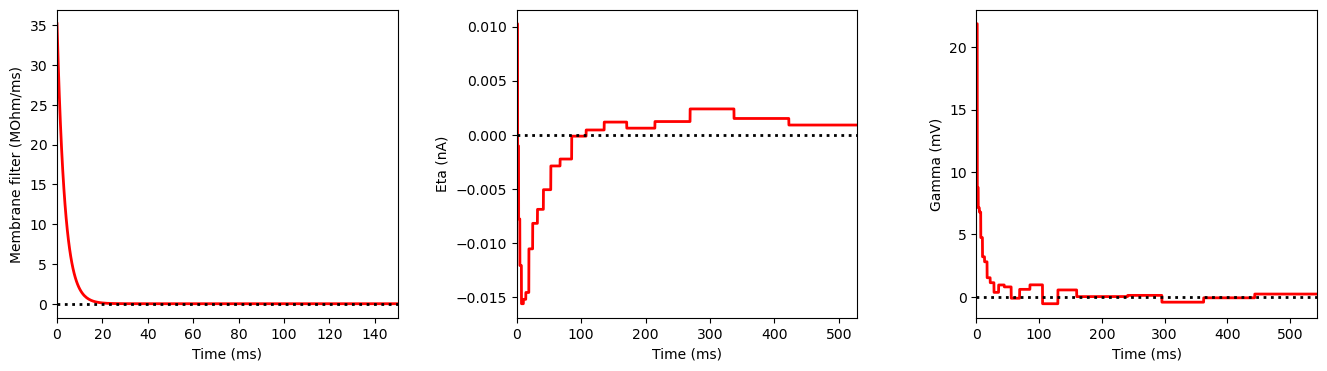

In [7]:
# Plot the model parameters
myGIF.printParameters()  
myGIF.plotParameters()   

In [8]:

I = myExp.trainingset_traces[0].I
V_exp = myExp.trainingset_traces[0].V
spks = myExp.trainingset_traces[0].spks*myExp.dt
(time, V_model, I_a, V_t, S_model,probs) = myGIF.simulate(I, myGIF.El)


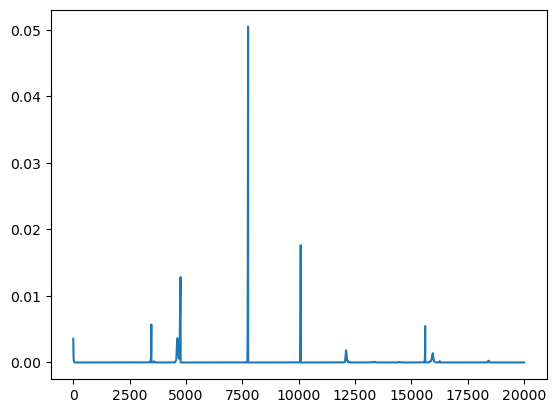

In [14]:
plt.plot(1-np.array(probs[1:20000]))
plt.scatter(time[:plot_time*20000], spks_model[:plot_time*20000]*85,c='red' ,marker='|')
plt.scatter(time[:plot_time*20000], spks_data[:plot_time*20000]*75,c='black',marker='|')

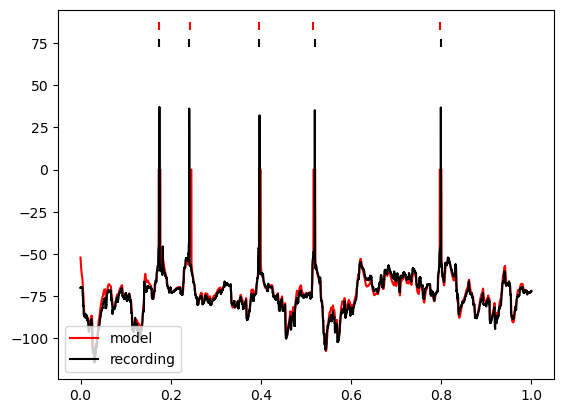

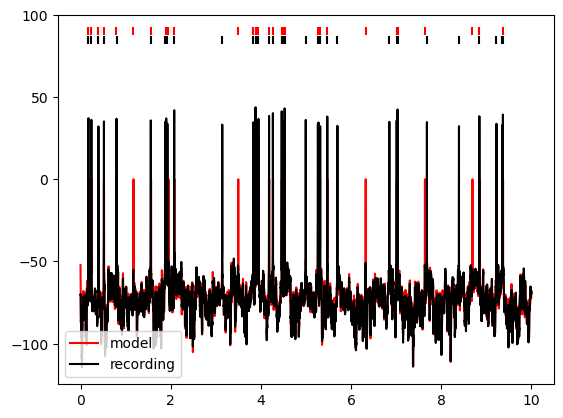

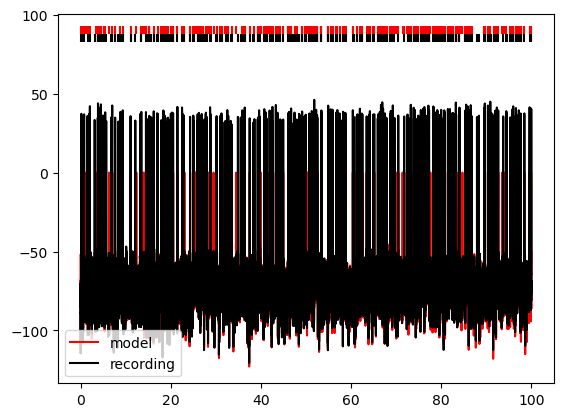

In [9]:

time  = time/1000

def getBinarySpikeTrain(V,spikes,dt,type='zero'):
    spikeinds  = np.int32(spikes/dt)
    if type=='zero':
        b_spikes = np.zeros(len(V))

    else:
        b_spikes = np.zeros(len(V))*np.nan
    b_spikes[spikeinds] =1
    return b_spikes


spks_model = getBinarySpikeTrain(V_model,S_model,myExp.dt,type='nan')
spks_data = getBinarySpikeTrain(V_exp,spks,myExp.dt,type='nan')


plot_time = 1 # s
plt.plot(time[:plot_time*20000],V_model[:plot_time*20000],c='red',label='model')
plt.plot(time[:plot_time*20000],V_exp[:plot_time*20000],c='black',label='recording')
plt.scatter(time[:plot_time*20000], spks_model[:plot_time*20000]*85,c='red' ,marker='|')
plt.scatter(time[:plot_time*20000], spks_data[:plot_time*20000]*75,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()



plot_time = 10 # s
plt.plot(time[:plot_time*20000],V_model[:plot_time*20000],c='red',label='model')
plt.plot(time[:plot_time*20000],V_exp[:plot_time*20000],c='black',label='recording')
plt.scatter(time[:plot_time*20000], spks_model[:plot_time*20000]*90,c='red' ,marker='|')
plt.scatter(time[:plot_time*20000], spks_data[:plot_time*20000]*85,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()


plot_time = 100 # s
plt.plot(time[:plot_time*20000],V_model[:plot_time*20000],c='red',label='model')
plt.plot(time[:plot_time*20000],V_exp[:plot_time*20000],c='black',label='recording')
plt.scatter(time[:plot_time*20000], spks_model[:plot_time*20000]*90,c='red' ,marker='|')
plt.scatter(time[:plot_time*20000], spks_data[:plot_time*20000]*85,c='black',marker='|')
plt.legend(loc='lower left')
plt.ion=True
plt.show()
# plt.imshow()


In [10]:
print(get_gamma_factor(S_model,spks,4,100*1000,1/20,rate_correction=False))
print(get_gamma_factor(S_model,spks,5,100*1000,1/20,rate_correction=False))
print(get_gamma_factor(S_model,spks,10,100*1000,1/20,rate_correction=False))


0.6774319362357877
0.6940272773431879
0.7558790112845781


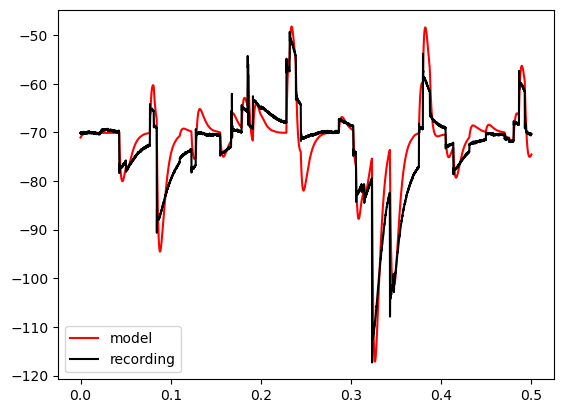

In [182]:

plot_start_time = 0 # s
plot_stop_time = 0.5 # s

plt.plot(time[int(plot_start_time*20000):int(plot_stop_time*20000)],V_model[int(plot_start_time*20000):int(plot_stop_time*20000)],c='red',label='model')
plt.plot(time[int(plot_start_time*20000):int(plot_stop_time*20000)],V_exp[int(plot_start_time*20000):int(plot_stop_time*20000)],c='black',label='recording')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_model[int(plot_start_time*20000):int(plot_stop_time*20000)]*85,c='red' ,marker='|')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_data[int(plot_start_time*20000):int(plot_stop_time*20000)]*75,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()



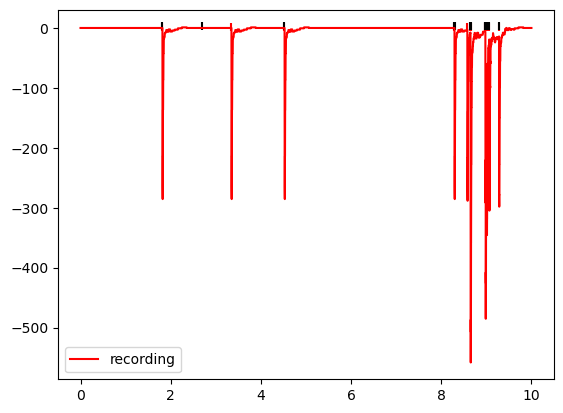

In [24]:

plot_start_time = 0 # s
plot_stop_time = 10 # s

plt.plot(time[int(plot_start_time*20000):int(plot_stop_time*20000)],I_a[int(plot_start_time*20000):int(plot_stop_time*20000)]/np.max(I_a[int(plot_start_time*20000):int(plot_stop_time*20000)]),c='red',label='recording')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_model[int(plot_start_time*20000):int(plot_stop_time*20000)]*2,c='red' ,marker='|')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_data[int(plot_start_time*20000):int(plot_stop_time*20000)]*2.5,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()

In [22]:
print(get_gamma_factor(S_model,spks,4,100*1000,1/20,rate_correction=False))
print(get_gamma_factor(S_model,spks,5,100*1000,1/20,rate_correction=False))
print(get_gamma_factor(S_model,spks,10,100*1000,1/20,rate_correction=False))


0.8462700232235367
0.8458169612741208
0.8580593447549996
